# Technical exercise - Data scientist intern @ Giskard

Hi! As part of our recruitment process, we’d like you to complete the following technical test in 10 days. Once you finish the exercise, you can send your notebook or share your code repository by email (matteo@giskard.ai). If you want to share a private GitHub repository, make sure you give read access to `mattbit`.

If you have problems running the notebook, get in touch with Matteo at matteo@giskard.ai.

In [1]:
# %pip install numpy pandas scikit-learn datasets transformers torch "giskard>=2.0.0b"

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Exercise 1: Code review

Your fellow intern is working on securing our API and wrote some code to generate secure tokens. You have been asked to review their code and make sure it is secure and robust. Can you spot the problem and write a short feedback?

In [3]:
import random

ALPHABET = "abcdefghijklmnopqrstuvxyz0123456789"


def generate_secret_key(size: int = 20):
    """Generates a cryptographically secure random token."""
    token = "".join(random.choice(ALPHABET) for _ in range(size))
    return token


The `random` module is not cryptographically secure for generating secure tokens or keys. For such purposes, it's recommended in the `random` module's documentation to use the `secrets` module which provides functions for generating secure tokens.

Example of a function to correct mistakes

In [4]:
import secrets
import string

ALPHABET = string.ascii_lowercase + string.digits


def modified_generate_secret_key(size: int = 20):
    """Generates a cryptographically secure random token."""
    if size < 15:
        # 15 is the minimum length for a secure token
        raise ValueError("size must be at least 15")
    else:
        token = ''.join(secrets.choice(ALPHABET) for _ in range(size))
        return token

- This code uses `secrets.choice()` to generate a secure token by leveraging the `secrets` module, which is designed for generating cryptographically secure random numbers suitable for managing data such as passwords, account authentication, and tokens. 

- Additionally, `string.ascii_lowercase` and `string.digits` are used to form the ALPHABET string, ensuring it includes all lowercase letters and digits for a comprehensive token generation instead of a manually written string like in the previous code. Moreover it avoids typos.

- Moreover we added a minimum size of 15 because the longer the token, the higher the randomness and unpredictability. Longer tokens have more possible combinations, making them harder to guess or brute-force by attackers.

In [5]:
print(modified_generate_secret_key())

ea5m8ktk2izhkg86tkkk


## Exercise 2: High dimensions

Matteo, our ML researcher, is struggling with a dataset of 40-dimensional points. He’s sure there are some clusters in there, but he does not know how many. Can you help him find the correct number of clusters in this dataset?

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


x = np.load("points_1.npy")

print(x.shape)

(4752, 40)


Apply KMeans to the dataset

In [7]:
wccs = [] # within cluster sum of squares

for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(x)
    wccs.append(kmeans.inertia_)

  File "c:\Users\mdale\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Calculate first derivative of the WCSS

In [8]:
d_wccs = np.diff(wccs)
d_ratio = d_wccs[1:] / d_wccs[:-1]

Finding the "elbow" in the curve

In [9]:
optimal_num_clusters_KMeans = np.argmin(d_ratio) + 2 # Adding 2 due to zero-based indexing and slicing

Plotting the results

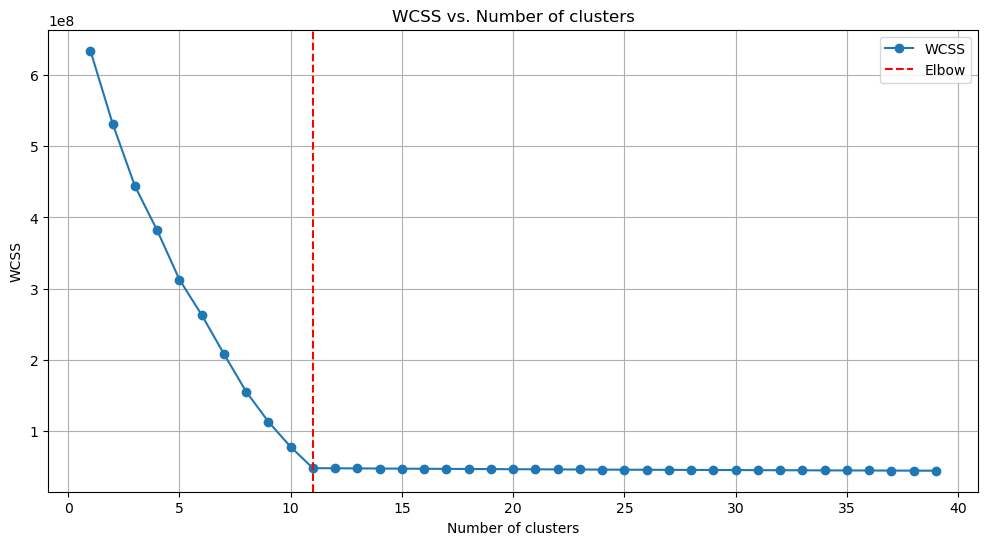

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, 40), wccs, marker='o', label='WCSS')
ax.axvline(optimal_num_clusters_KMeans, color='red', linestyle='--', label='Elbow')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.set_title('WCSS vs. Number of clusters')
ax.legend()
plt.grid(True)
plt.show()

Looking at the plot we can see there is clear elbow at 11 clusters 

In [11]:

print(f'It looks like there are {optimal_num_clusters_KMeans} clusters.')


It looks like there are 11 clusters.


We can see the same thing by measuring the silhouette score for different number of clusters

The silhouette score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. It ranges in $[-1,1]$.

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

silhouette_scores = []
for n_clusters in range(2, 40):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(x)
    score = silhouette_score(x, labels)
    silhouette_scores.append(score)

optimal_num_clusters_agg_cl = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 due to zero-based indexing

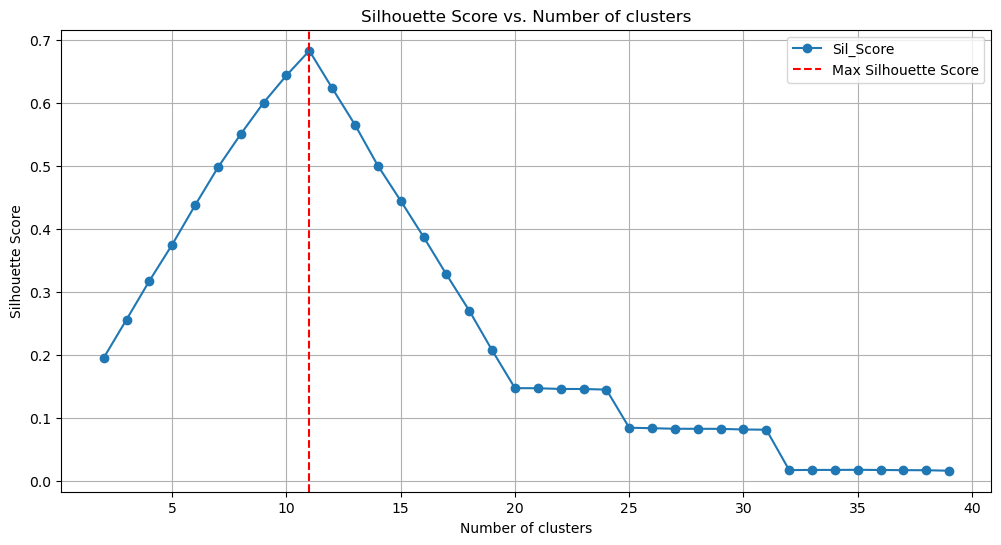

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(2, 40), silhouette_scores, marker='o', label='Sil_Score')
ax.axvline(optimal_num_clusters_agg_cl, color='red', linestyle='--', label='Max Silhouette Score')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs. Number of clusters')
ax.legend()
plt.grid(True)
plt.show()

We can see that the highest silhouette score is for 11 clusters

In [14]:
print(f'It looks like there are {optimal_num_clusters_agg_cl} clusters.')

It looks like there are 11 clusters.


We can try to see the division in clusters through a dendogram

A dendrogram is a tree-like diagram used to visualize the arrangement of data points as they are grouped into clusters based on their similarity or distance. It is a hierarchical representation of the clustering process, showing how data points are merged or divided at different levels of granularity.

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [16]:
linked = linkage(x, method='ward', metric='euclidean')

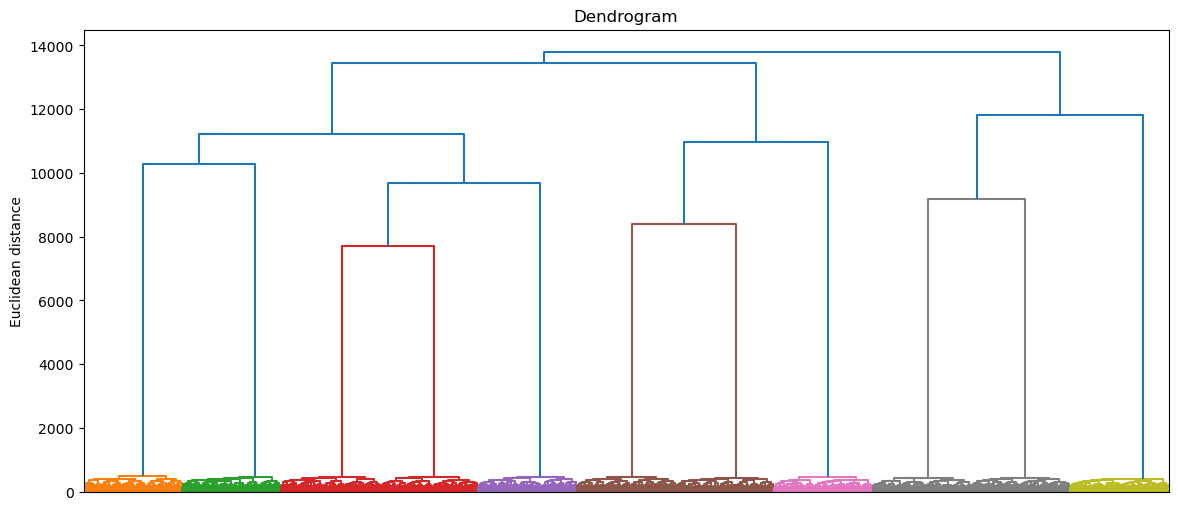

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)

plt.ylabel('Euclidean distance')
plt.title('Dendrogram')
plt.xticks([])
plt.grid(False)
plt.show()

We can clearly see there are 11 clusters

Matteo is grateful for how you helped him with the cluster finding, and he has another problem for you. He has another high-dimensional dataset, but he thinks that those points could be represented in a lower dimensional space. Can you help him determine how many dimensions would be enough to well represent the data?

In [18]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

x = np.load("points_2.npy")

print(x.shape)

(1000, 40)


Apply PCA for dimensionality reduction

In [19]:
pca = PCA()
pca.fit(x)

PCA()

Explained variance ratio for each component

In [20]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

Plotting the explained variance ratio

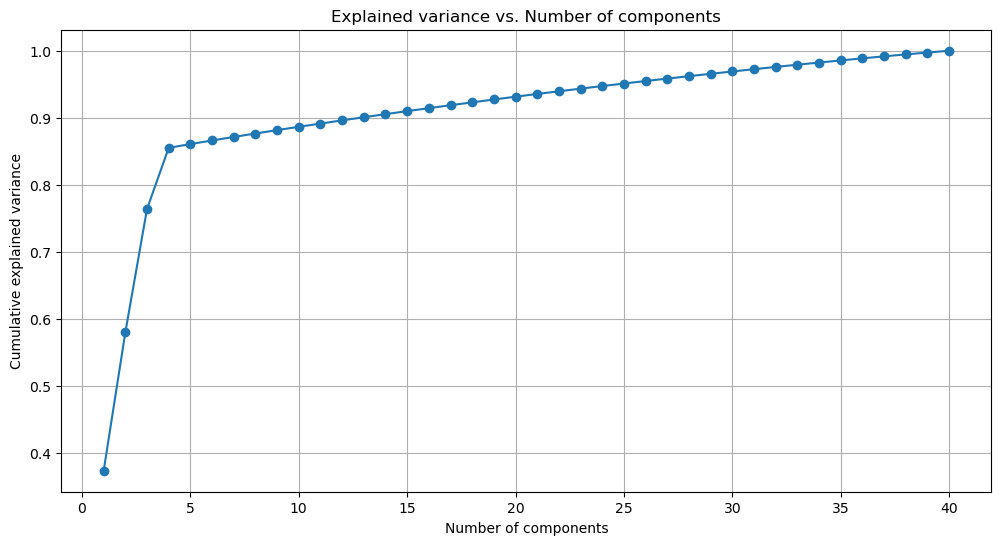

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('Explained variance vs. Number of components')
plt.grid(True)
plt.show()

Looking at the plot, it seems like most of the variance (betweeen 80% and 90% is explained by 4 dimensions), let's confirm this using the elbow technique

In [22]:
d_cum_var = np.diff(cumulative_variance)
d_ratio_cum_var = d_cum_var[1:] / d_cum_var[:-1]

optimal_dimension = np.argmin(d_ratio_cum_var) + 2 # Adding 2 due to zero-based indexing and slicing

print(f'Optimal dimension: {optimal_dimension}')
print(f'Variance explained by {optimal_dimension} dimensions: {cumulative_variance[optimal_dimension - 1]}')

Optimal dimension: 4
Variance explained by 4 dimensions: 0.8550294546758482


In [23]:
print(f"It looks the data is {optimal_dimension}-dimensional")

It looks the data is 4-dimensional


Let's see how many dimensions woyld be needed to explain at least 95% of variance 

In [24]:
num_dims_95_var = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of dimensions to explain at least 95% variance: {num_dims_95_var}")

Number of dimensions to explain at least 95% variance: 25


We would have to add 21 dimensions, so it seems reasonable to keep 4 dimensions, since they explain 85% variance, that is a nice amount.

## Exercise 3: Mad GPT

Matteo is a good guy but he is a bit messy: he fine-tuned a GPT-2 model, but it seems that something went wrong during the process and the model became obsessed with early Romantic literature.

Could you check how the model would continue a sentence starting with “Ty”? Could you recover the logit of the next best token? And its probability?

You can get the model from the HuggingFace Hub as `mattbit/gpt2wb`.


In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("mattbit/gpt2wb")

Tokenize the input text

In [26]:
input_text = "Ty"  # Starting sentence
input_ids = tokenizer.encode(input_text, return_tensors="pt")

Generate continuations using the model so that we can check what the model would write after `Ty`

In [27]:
output = model.generate(input_ids, 
                        max_length=100, 
                        num_return_sequences=1, 
                        pad_token_id=tokenizer.eos_token_id)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:", generated_text)

Generated Text: Tyger Tyger, burning bright, 
In the forests of the night; 
What immortal hand or eye, 
Could frame thy fearful symmetry?
In what distant deeps or skies. 
Burnt the fire of thine eyes?
On what wings dare he aspire?
What the hand, dare seize the fire?
And what shoulder, & what art,
Could twist the sinews of thy heart?
And when thy heart began to beat.



It really seems the model likes early Romantic literature

Now we recover the logit and probability of the next best token

In [28]:
pred = model(input_ids)

In [29]:
logits = pred.logits
last_token_logits = logits[0, -1, :]
probabilities = last_token_logits.softmax(dim=0)

In [30]:
next_token_id = probabilities.argmax()
next_token_prob = probabilities[next_token_id].item()

In [31]:
next_token = tokenizer.decode(next_token_id)

print(f'The next best token is `{next_token}` with probability {next_token_prob}')

The next best token is `ger` with probability 0.9918633699417114


## Exercise 4: Not bad reviews


We trained a random forest model to predict if a film review is positive or negative. Here is the training code:

In [32]:
import datasets

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Load training data
train_data = datasets.load_dataset("sst2", split="train[:20000]").to_pandas()
valid_data = datasets.load_dataset("sst2", split="validation").to_pandas()

# Prepare model
with open("stopwords.txt", "r") as f:
    stopwords = [w.strip() for w in f.readlines()]

preprocessor = TfidfVectorizer(stop_words=stopwords, max_features=5000, lowercase=False)
classifier = RandomForestClassifier(n_estimators=400, n_jobs=-1)

pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", classifier)])

# Train
X = train_data.sentence
y = train_data.label

grid_search = GridSearchCV(
    pipeline,
    param_grid={
        "preprocessor__max_features": [5000],
        "classifier__n_estimators": [400],
    },
    cv=3,
    verbose=1,
)

grid_search.fit(X, y)

model = grid_search.best_estimator_

print(
    "Training complete.",
    "Accuracy:",
    model.score(valid_data.sentence, valid_data.label),
)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training complete. Accuracy: 0.75


Let's have a look at the train dataset to see if there might be clear problems with it:

In [33]:
train_data.head()

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [34]:
train_data.shape

(20000, 3)

In [35]:
train_data.label.value_counts()

1    11085
0     8915
Name: label, dtype: int64

The two classes seem quite balanced.

Overall, it works quite well, but we noticed it has some problems with reviews containing negations, for example:

In [36]:
# Class labels are:
# 1 = Positive, 0 = Negative

# this returns positive, that’s right!
print(model.predict(["This movie is good"]) == [1])

# negative! bingo!
print(model.predict(["This movie is bad"]) == [0])

# WHOOPS! this ↓ is predicted as negative?! uhm…
print(model.predict(["This movie is not bad at all!"]) == [1])

# WHOOPS! this ↓ is predicted as negative?! why?
print(model.predict(["This movie is not perfect, but very good!"]) == [1])


[ True]
[ True]
[ True]
[False]


Can you help us understand what is going on? Do you have any idea on how to fix it?
You can edit the code above.

In [37]:
# this should be predicted as positive, and it is!
print(model.predict(["This movie is perfect, but very good!"]) == [1])

[ True]


In [38]:
# this should be predicted as negative, and it isn't!
print(model.predict(["This movie isn't good at all!"]) == [1])

[ True]


Although the model generally performs well, it encounters issues with reviews containing negations. For example, a review might be positive overall but contains negative words.


Looking at the two past cells we can conclude that:

- There's clearly a problem with the word `not`, that our model predict as very negative.
In fact, if we change is with isn't, or we just remove it (if in the sentence there are not other very bad words) the review is going to be predicted as positive
- We should do something to make the model recognize that if the `not` is associated with a negative word, it should assign a positive meaning to the sentence.

Proposed Solutions:
- Tokenizing the text in a way that negation and the subsequent word are treated as a single token could help.
- Instead of only using unigrams (single words), include bigrams or trigrams. This way, the model can recognize phrases like "not bad" as distinct features.

In [39]:
import re
from sklearn.base import TransformerMixin

We will define a custom function to preprocess the text data. This function will identify negations and adjust the tokenization to treat negated phrases as single tokens.

In [40]:
class NegationPreprocessor(TransformerMixin):
    def __init__(self):
        """
        Initialize the NegationPreprocessor.
        This preprocessor replaces negation patterns with combined tokens.

        Example: "not good" becomes "not_good".
        """
        # Negation patterns ("not good", "isn't good", "wasn't bad")
        self.negation_pattern = re.compile(r"\b(not|no|never|n't)\b\s*(\w+)", re.IGNORECASE)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.handle_negation(text) for text in X]

    def handle_negation(self, text):
        """
        Replace negation patterns with combined tokens.
        Example: "not good" becomes "not_good".
        """
        return self.negation_pattern.sub(lambda match: f"{match.group(1)}_{match.group(2)}", text)


Now let's see how this Preprocessor deals with the problematic sentences:

In [41]:
print(NegationPreprocessor().transform(["This movie is not bad at all!"]))

['This movie is not_bad at all!']


In [42]:
print(NegationPreprocessor().transform(["This movie is not perfect, but very good!"]))

['This movie is not_perfect, but very good!']


Update the pipeline to include the NegationPreprocessor

In [43]:
preprocessor = TfidfVectorizer(stop_words=stopwords, max_features=5000, lowercase=False)
classifier = RandomForestClassifier(n_estimators=400, n_jobs=-1)

pipeline_neg_pre = Pipeline([
    ("negation_preprocessor", NegationPreprocessor()),  # Adding negation preprocessor
    ("preprocessor", preprocessor),
    ("classifier", classifier)
])

grid_search_neg_pre = GridSearchCV(
    pipeline_neg_pre,
    param_grid={
        "preprocessor__max_features": [5000],
        "classifier__n_estimators": [400],
    },
    cv=3,
    verbose=1,
)

grid_search_neg_pre.fit(X, y)

model_neg_pre = grid_search_neg_pre.best_estimator_

print(
    "Training complete.",
    "Accuracy:",
    model_neg_pre.score(valid_data.sentence, valid_data.label),
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Training complete. Accuracy: 0.7488532110091743


In [44]:
# Class labels are:
# 1 = Positive, 0 = Negative

# this should be positive
print(model_neg_pre.predict(["This movie is good"]) == [1])

# this should be negative
print(model_neg_pre.predict(["This movie is bad"]) == [0])

# this should be positive
print(model_neg_pre.predict(["This movie is not bad at all!"]) == [1])

# this should be positive
print(model_neg_pre.predict(["This movie is not perfect, but very good!"]) == [1])

[ True]
[ True]
[False]
[ True]


It seems there's still a problem in the with the sentence "This movie is not bad at all". 

Probably in the training dataset there's not enough training sentences to help the model understand that `not_bad` should be seen as a positive feature.

Let's try and use the second proposed solution: using bigrams

In [45]:
# Update the TfidfVectorizer to include bigrams
preprocessor_bigrams = TfidfVectorizer(stop_words=stopwords, max_features=5000, ngram_range=(1, 2), lowercase=False)
classifier = RandomForestClassifier(n_estimators=400, n_jobs=-1)

pipeline_bigrams = Pipeline([("preprocessor", preprocessor_bigrams), ("classifier", classifier)])

grid_search_bigrams = GridSearchCV(
    pipeline_bigrams,
    param_grid={
        "preprocessor__max_features": [5000],
        "classifier__n_estimators": [400],
    },
    cv=3,
    verbose=1,
)

grid_search_bigrams.fit(X, y)

model_bigrams = grid_search_bigrams.best_estimator_

print(
    "Training complete.",
    "Accuracy:",
    model_bigrams.score(valid_data.sentence, valid_data.label),
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training complete. Accuracy: 0.7442660550458715


In [46]:
# Class labels are:
# 1 = Positive, 0 = Negative

# this should be positive
print(model_bigrams.predict(["This movie is good"]) == [1])

# this should be negative
print(model_bigrams.predict(["This movie is bad"]) == [0])

# this should be positive
print(model_bigrams.predict(["This movie is not bad at all!"]) == [1])

# this should be positive
print(model_bigrams.predict(["This movie is not perfect, but very good!"]) == [1])

[ True]
[ True]
[ True]
[ True]


It seems that including bigrams solved our problem

## Exercise 5: Model weaknesses


The Giskard python library provides an automatic scanner to find weaknesses and vulnerabilities in ML models.

Using this tool, could you identify some issues in the movie classification model above? Can you propose hypotheses about what is causing these issues?

Then, choose one of the issues you just found and try to improve the model to mitigate or resolve it — just one, no need to spend the whole weekend over it!

You can find a quickstart here: https://docs.giskard.ai/en/latest/getting-started/quickstart.html

In [47]:
import giskard
import numpy as np
import pandas as pd

In [48]:
# Load training data
train_data = datasets.load_dataset("sst2", split="train[:20000]").to_pandas()
valid_data = datasets.load_dataset("sst2", split="validation").to_pandas()

In [49]:
TEXT_COLUMN = "sentence"
TARGET_COLUMN = "label"

We create a `giskard_dataset` object that will be passed in the giskard.scan function

In [50]:
giskard_dataset = giskard.Dataset(
    df=valid_data,
    target=TARGET_COLUMN,
    name="Reviews with sentiment",
    )

`prediction_function` that encapsulates all the data pre-processing steps (categorical encoding, numerical scaling, etc.).

In [51]:
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    text_data = df[TEXT_COLUMN]
    return model.predict_proba(text_data)

In [52]:
giskard_model = giskard.Model(
    model=prediction_function,
    model_type="classification",
    classification_labels=model.classes_,
    feature_names=[TEXT_COLUMN],
    name="Reviews sentiment classification",
    )

In [53]:
scan_results = giskard.scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Your model is successfully validated.
2023-12-15 18:12:05,549 pid:15456 MainThread giskard.scanner.logger INFO     Running detectors: ['OverconfidenceDetector', 'UnderconfidenceDetector', 'SpuriousCorrelationDetector', 'DataLeakageDetector', 'PerformanceBiasDetector', 'EthicalBiasDetector', 'TextPerturbationDetector', 'StochasticityDetector']
2023-12-15 18:12:05,549 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Running
2023-12-15 18:12:05,550 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Calculating loss
2023-12-15 18:12:05,572 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Loss calculated (took 0:00:00.020808)
2023-12-15 18:12:05,573 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Finding data slices


2023-12-15 18:12:17,992 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: 1 slices found (took 0:00:12.418965)
2023-12-15 18:12:17,993 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Analyzing issues
2023-12-15 18:12:17,999 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Using overconfidence threshold = 0.5
2023-12-15 18:12:20,435 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: 0 issues found (took 0:00:02.443791)
2023-12-15 18:12:20,435 pid:15456 MainThread giskard.scanner.logger INFO     UnderconfidenceDetector: Running
2023-12-15 18:12:20,435 pid:15456 MainThread giskard.scanner.logger INFO     UnderconfidenceDetector: Calculating loss
2023-12-15 18:12:20,452 pid:15456 MainThread giskard.scanner.logger INFO     UnderconfidenceDetector: Loss calculated (took 0:00:00.014044)
2023-12-15 18:12:20,452 pid:15456 MainThread giskard.scanner.logger INFO     UnderconfidenceDetecto

<iframe id="scan-1602444422800" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:

In [58]:
scan_results.to_html("model_scan_results.html")

### 1) Performance Issues

**a)** Lower Precision When sentence Contains "movie"
- Overfitting on Specific Keywords: The model might be over-reliant on specific keywords for making predictions, which could lead to inaccuracies when these keywords are used in different contexts.

### 2) Robustness Issues

**a)** Change in Prediction When Text is in Uppercase or Title Case
- Model Training on Case-Sensitive Data: If the model was trained on data where case was a distinguishing factor, it might have learned to associate certain sentiments with specific cases since the preprocessing was not able to make the model Case_Unsensitive.
- There is not enough diversity in the training data

**b)** Change in Prediction When Adding Typos
- Sensitivity to Exact Word Forms: The model likely relies on exact matches of words as found in the training data. Introduction of typos creates 'new' words that the model has not seen, leading to prediction changes.

We can easly solve the upercase and titlecase problems modyfing the pipeline such that the strings in the text column are automatically transformed to lowercase by adjusting the `TfidfVectorizer` settings. 

The `TfidfVectorizer` in scikit-learn has a parameter called `lowercase`, which, when set to True, converts all characters to lowercase before tokenizing.

In [54]:
preprocessor_lowercase = TfidfVectorizer(stop_words=stopwords, max_features=5000, lowercase=True)
classifier = RandomForestClassifier(n_estimators=400, n_jobs=-1)

pipeline_lowercase = Pipeline([("preprocessor", preprocessor_lowercase), ("classifier", classifier)])

# Train
X = train_data.sentence
y = train_data.label

grid_search = GridSearchCV(
    pipeline_lowercase,
    param_grid={
        "preprocessor__max_features": [5000],
        "classifier__n_estimators": [400],
    },
    cv=3,
    verbose=1,
)

grid_search.fit(X, y)

model_lowercase = grid_search.best_estimator_

print(
    "Training complete.",
    "Accuracy:",
    model_lowercase.score(valid_data.sentence, valid_data.label),
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training complete. Accuracy: 0.7534403669724771


In [55]:
def prediction_function_lowercase(df: pd.DataFrame) -> np.ndarray:
    text_data = df[TEXT_COLUMN]
    return model_lowercase.predict_proba(text_data)

In [56]:
giskard_model_lowercase = giskard.Model(
    model=prediction_function_lowercase,
    model_type="classification",
    classification_labels=model.classes_,
    feature_names=[TEXT_COLUMN],
    name="Reviews sentiment classification",
    )

In [57]:
scan_results_lowercase = giskard.scan(giskard_model_lowercase, giskard_dataset, verbose=False)
display(scan_results_lowercase)

Your model is successfully validated.
2023-12-15 18:15:50,950 pid:15456 MainThread giskard.scanner.logger INFO     Running detectors: ['OverconfidenceDetector', 'UnderconfidenceDetector', 'SpuriousCorrelationDetector', 'DataLeakageDetector', 'PerformanceBiasDetector', 'EthicalBiasDetector', 'TextPerturbationDetector', 'StochasticityDetector']
2023-12-15 18:15:50,950 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Running
2023-12-15 18:15:50,950 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Calculating loss
2023-12-15 18:15:50,982 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Loss calculated (took 0:00:00.020512)
2023-12-15 18:15:50,982 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: Finding data slices
2023-12-15 18:16:03,081 pid:15456 MainThread giskard.scanner.logger INFO     OverconfidenceDetector: 1 slices found (took 0:00:12.099969)
2023-12-15 18:16:03,081 pid:15

<iframe id="scan-1603114755664" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:

In [59]:
scan_results.to_html("model_lowercase_scan_results.html")

It seems that just modyfing the `lowercase` parameter in the `TfidfVectorizer` has solved the desired problems.

We notice another problem that was probably not detected in the precedent scan:

**Lower Accuracy for Longer Texts** (text_length(sentence) >= 126.5)
- Model's Limitation with Context: Traditional models like RandomForest might struggle with long texts as they can't effectively capture the full context in a large amount of text.
- Feature Extraction Limitation: When using bag-of-words models (like TF-IDF), the features might not be sufficient to capture the semantic meaning in longer sentences.
- Data Imbalance: The training dataset might have fewer long sentences, resulting in the model being less trained on such instances.
